# Stock price prediction with LSTM
## Stock price forecasting for Dino S.A. using machine learning models based on historical data from 2017 to 2025.

## Project Goal

The goal of this project is to create and test a predictive model that will enable forecasting the future stock prices of the company Dino S.A. based on its historical data and data concerning other financial instruments. The task of the model is to predict the closing price of Dino's stock based on explanatory variables.

In the project, libraries for data analysis, visualization, and building a linear regression model will be imported.

## Dataset Description

The data was downloaded in CSV format from the portal **stooq.pl**.

**Dataset includes:**

- Dino company stock data  
- Daily quotations  
- Time period: **April 19, 2017 – April 19, 2025**  
- Over **2,000 observations**

---

## Financial Instrument Description

**DINO POLSKA S.A.** is a dynamically growing Polish supermarket chain operating in the food retail sector.  
The company has secured a strong position in the domestic market and is listed on the **Warsaw Stock Exchange (WSE)**.  
Its shares are part of the **WIG20** index, indicating high market capitalization and investor interest.

Due to:

- an upward trend in share prices,  
- solid financial performance,  
- and rapid store expansion,  

**DINO** attracts attention from both individual and institutional investors.  
The volatility of its stock and ties to consumer indicators make the company a compelling subject for predictive modeling in this project.

---

## Variable Description

The dataset contains standard stock market variables describing the behavior of financial instruments.

The main **dependent variable** is the **closing price** of DINO shares, i.e., the stock's value at the end of a trading day.  
It is frequently used in both predictive and investment analysis.

Other variables — such as **Open**, **High**, **Low**, and **Volume** — serve as **explanatory variables**, potentially affecting the closing price.

In addition to DINO's data, the dataset includes financial indicators such as:

- Stock indices: **WIG, mWIG40, sWIG80, DAX**  
- Exchange rates: **EUR/PLN, USD/PLN**

These were added as **auxiliary features**, allowing the analysis of external factors influencing DINO’s stock behavior.

---

### Variables

| Variable     | Description                        |
|--------------|------------------------------------|
| `Date`       | Quotation date                     |
| `Open`       | Opening price                      |
| `High`       | Highest price of the day           |
| `Low`        | Lowest price of the day            |
| `Close`      | **Closing price** (target)         |
| `Volume`     | Trading volume                     |

---

### Target Variable

- `Close` (DINO closing price) – the value to be predicted by the model.

---

### Explanatory Variables

- `Open`, `High`, `Low`, `Volume` for DINO
- `Close`, `Open`, `High`, `Low`, `Volume` for other instruments:
  - **WIG, mWIG40, sWIG80, DAX, EUR/PLN, USD/PLN**


### Importing Required Libraries

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive

from sklearn.model_selection import train_test_split
from ipywidgets import interact, interact_manual
from ipywidgets import interactive
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

### Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


### Loading Historical Stock Data for DINO

The first step is to load the main input dataset.  
This is the `dnp_d.csv` file, which contains the **explanatory variables**.

In [ ]:
main_data = pd.read_csv('/content/data/MyDrive/SIML/zmienne/dnp_d.csv', index_col="Data")

In this step, we load additional files that contain the **explanatory variables** used for building the predictive model.

In [ ]:
files = os.listdir('/content/data/MyDrive/SIML/zmienne/')
files.remove('dnp_d.csv')
files

['dax_d.csv',
 'eurpln_d.csv',
 'wig_d.csv',
 'swig80_d.csv',
 'mwig40_d.csv',
 'usdpln_d.csv']

We merge the different datasets into a single consolidated data file to facilitate analysis and modeling.

In [ ]:
for file in files:
    right=pd.read_csv('/content/data/MyDrive/SIML/zmienne/'+file, index_col='Data', engine='python')
    main_data=main_data.merge(right=right, how="inner", left_index=True, right_index=True, copy=False , suffixes=('','_'+file[:-4]) )

The merged dataset is saved to a file for future use and easy access during analysis.

<div style="background-color: pink; padding: 10px;">
    
### 1. Data Extraction

</div>

In [ ]:
main_data.to_csv('combined_data.csv')

The columns in our combined file are prefixed with the filename to maintain uniqueness.

In [ ]:
main_data.head()

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_dax_d,Najwyzszy_dax_d,Najnizszy_dax_d,Zamkniecie_dax_d,Wolumen_dax_d,...,Wolumen_swig80_d,Otwarcie_mwig40_d,Najwyzszy_mwig40_d,Najnizszy_mwig40_d,Zamkniecie_mwig40_d,Wolumen_mwig40_d,Otwarcie_usdpln_d,Najwyzszy_usdpln_d,Najnizszy_usdpln_d,Zamkniecie_usdpln_d
Data,,,,,,,,,,,,,,,,,,,,,
2017-04-19,36.15,37.88,36.15,37.50,10267297,12014.03,12040.23,12001.86,12016.45,85822603,...,8366803.0,4688.74,4722.81,4682.42,4721.64,7733478.0,3.94210,3.97694,3.94080,3.97460
2017-04-20,37.45,38.20,37.20,38.00,1361524,11968.06,12050.66,11941.57,12027.32,85378069,...,10649134.0,4735.04,4740.97,4703.36,4721.41,7832028.0,3.97505,3.98339,3.95642,3.98237
2017-04-21,38.14,39.50,38.08,39.19,1513875,12032.78,12091.33,12009.12,12048.57,109697849,...,10002901.0,4728.16,4742.57,4695.26,4707.81,7562024.0,3.98365,4.00374,3.97695,3.98887
2017-04-24,39.50,39.50,38.60,39.36,664260,12296.56,12456.18,12289.37,12454.98,191815012,...,10752147.0,4725.89,4777.07,4720.41,4775.38,6125539.0,3.89215,3.93327,3.89030,3.90635
2017-04-25,38.86,39.94,38.72,39.15,920443,12457.83,12482.90,12439.11,12467.04,94319014,...,27212338.0,4811.72,4848.10,4791.76,4848.10,13837914.0,3.90615,3.91115,3.85765,3.86215



<div style="background-color: pink; padding: 10px;">
    
### 2. Data Preparation

</div>

Removing missing values (NaN) from the dataset.

In [ ]:
data = pd.read_csv('combined_data.csv')

data

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_dax_d,Najwyzszy_dax_d,Najnizszy_dax_d,Zamkniecie_dax_d,...,Wolumen_swig80_d,Otwarcie_mwig40_d,Najwyzszy_mwig40_d,Najnizszy_mwig40_d,Zamkniecie_mwig40_d,Wolumen_mwig40_d,Otwarcie_usdpln_d,Najwyzszy_usdpln_d,Najnizszy_usdpln_d,Zamkniecie_usdpln_d
0,2017-04-19,36.15,37.88,36.15,37.50,10267297,12014.03,12040.23,12001.86,12016.45,...,8366803.0,4688.74,4722.81,4682.42,4721.64,7733478.0,3.94210,3.97694,3.94080,3.97460
1,2017-04-20,37.45,38.20,37.20,38.00,1361524,11968.06,12050.66,11941.57,12027.32,...,10649134.0,4735.04,4740.97,4703.36,4721.41,7832028.0,3.97505,3.98339,3.95642,3.98237
2,2017-04-21,38.14,39.50,38.08,39.19,1513875,12032.78,12091.33,12009.12,12048.57,...,10002901.0,4728.16,4742.57,4695.26,4707.81,7562024.0,3.98365,4.00374,3.97695,3.98887
3,2017-04-24,39.50,39.50,38.60,39.36,664260,12296.56,12456.18,12289.37,12454.98,...,10752147.0,4725.89,4777.07,4720.41,4775.38,6125539.0,3.89215,3.93327,3.89030,3.90635
4,2017-04-25,38.86,39.94,38.72,39.15,920443,12457.83,12482.90,12439.11,12467.04,...,27212338.0,4811.72,4848.10,4791.76,4848.10,13837914.0,3.90615,3.91115,3.85765,3.86215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,2025-04-11,467.00,471.90,461.20,466.00,143076,20787.06,20796.45,20114.54,20374.10,...,3272218.0,6933.33,6995.31,6914.41,6951.05,10035115.0,3.80780,3.80815,3.74445,3.77440
1986,2025-04-14,471.70,487.70,466.00,486.80,305580,20802.42,21048.33,20698.91,20954.83,...,2869848.0,7029.04,7129.95,7029.04,7129.95,8683243.0,3.79102,3.79116,3.74592,3.77310
1987,2025-04-15,487.90,492.40,481.80,488.00,219598,21076.06,21288.12,21042.27,21253.70,...,6076329.0,7139.81,7235.39,7086.04,7160.91,18646538.0,3.77250,3.81154,3.76277,3.80680
1988,2025-04-16,488.00,494.50,485.90,492.50,259930,21117.78,21315.96,20956.38,21311.02,...,4851190.0,7115.22,7194.81,7096.50,7172.14,8487046.0,3.80675,3.80675,3.75090,3.75335


In [ ]:
data = pd.read_csv('combined_data.csv')
print('Data before NaN removal:', len(data), 'number of columns', len(data.columns))

data = data.dropna()
print('Data after NaN removal:', len(data), 'number of columns', len(data.columns))

Data before NaN removal: 1990 number of columns 34
Data after NaN removal: 1990 number of columns 34


In [ ]:
data.head()

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_dax_d,Najwyzszy_dax_d,Najnizszy_dax_d,Zamkniecie_dax_d,...,Wolumen_swig80_d,Otwarcie_mwig40_d,Najwyzszy_mwig40_d,Najnizszy_mwig40_d,Zamkniecie_mwig40_d,Wolumen_mwig40_d,Otwarcie_usdpln_d,Najwyzszy_usdpln_d,Najnizszy_usdpln_d,Zamkniecie_usdpln_d
0,2017-04-19,36.15,37.88,36.15,37.50,10267297,12014.03,12040.23,12001.86,12016.45,...,8366803.0,4688.74,4722.81,4682.42,4721.64,7733478.0,3.94210,3.97694,3.94080,3.97460
1,2017-04-20,37.45,38.20,37.20,38.00,1361524,11968.06,12050.66,11941.57,12027.32,...,10649134.0,4735.04,4740.97,4703.36,4721.41,7832028.0,3.97505,3.98339,3.95642,3.98237
2,2017-04-21,38.14,39.50,38.08,39.19,1513875,12032.78,12091.33,12009.12,12048.57,...,10002901.0,4728.16,4742.57,4695.26,4707.81,7562024.0,3.98365,4.00374,3.97695,3.98887
3,2017-04-24,39.50,39.50,38.60,39.36,664260,12296.56,12456.18,12289.37,12454.98,...,10752147.0,4725.89,4777.07,4720.41,4775.38,6125539.0,3.89215,3.93327,3.89030,3.90635
4,2017-04-25,38.86,39.94,38.72,39.15,920443,12457.83,12482.90,12439.11,12467.04,...,27212338.0,4811.72,4848.10,4791.76,4848.10,13837914.0,3.90615,3.91115,3.85765,3.86215


Displaying the data types in our analyzed dataset.

In [ ]:
data.dtypes

,0
Data,object
Otwarcie,float64
Najwyzszy,float64
Najnizszy,float64
Zamkniecie,float64
Wolumen,int64
Otwarcie_dax_d,float64
Najwyzszy_dax_d,float64
Najnizszy_dax_d,float64
Zamkniecie_dax_d,float64


<div style="background-color: pink; padding: 10px;">
    
### 3. Correlations

</div>

The charts below show how correlated our data is.  
A value closer to 1 indicates a stronger correlation.



Creating a plot that displays our correlations with column names.

Using seaborn's heatmap to present the correlation matrix.

First, we applied a clearer color scheme (`rocket`), which better reflects the strength and direction of correlations — positive values appear lighter, while negative values are more vivid (purple).

We also enabled full annotation of correlation values (`annot=True`) with precision up to two decimal places, which greatly facilitates reading the data without having to interpret raw numbers.

The plot size was increased (`figsize=(22, 18)`) so that variable labels do not overlap and are more readable.

Additionally, setting `square=True` ensures equal cell proportions, improving the aesthetics and clarity of the plot.

Overall, this presentation looks more professional and is better suited for exploratory data analysis.

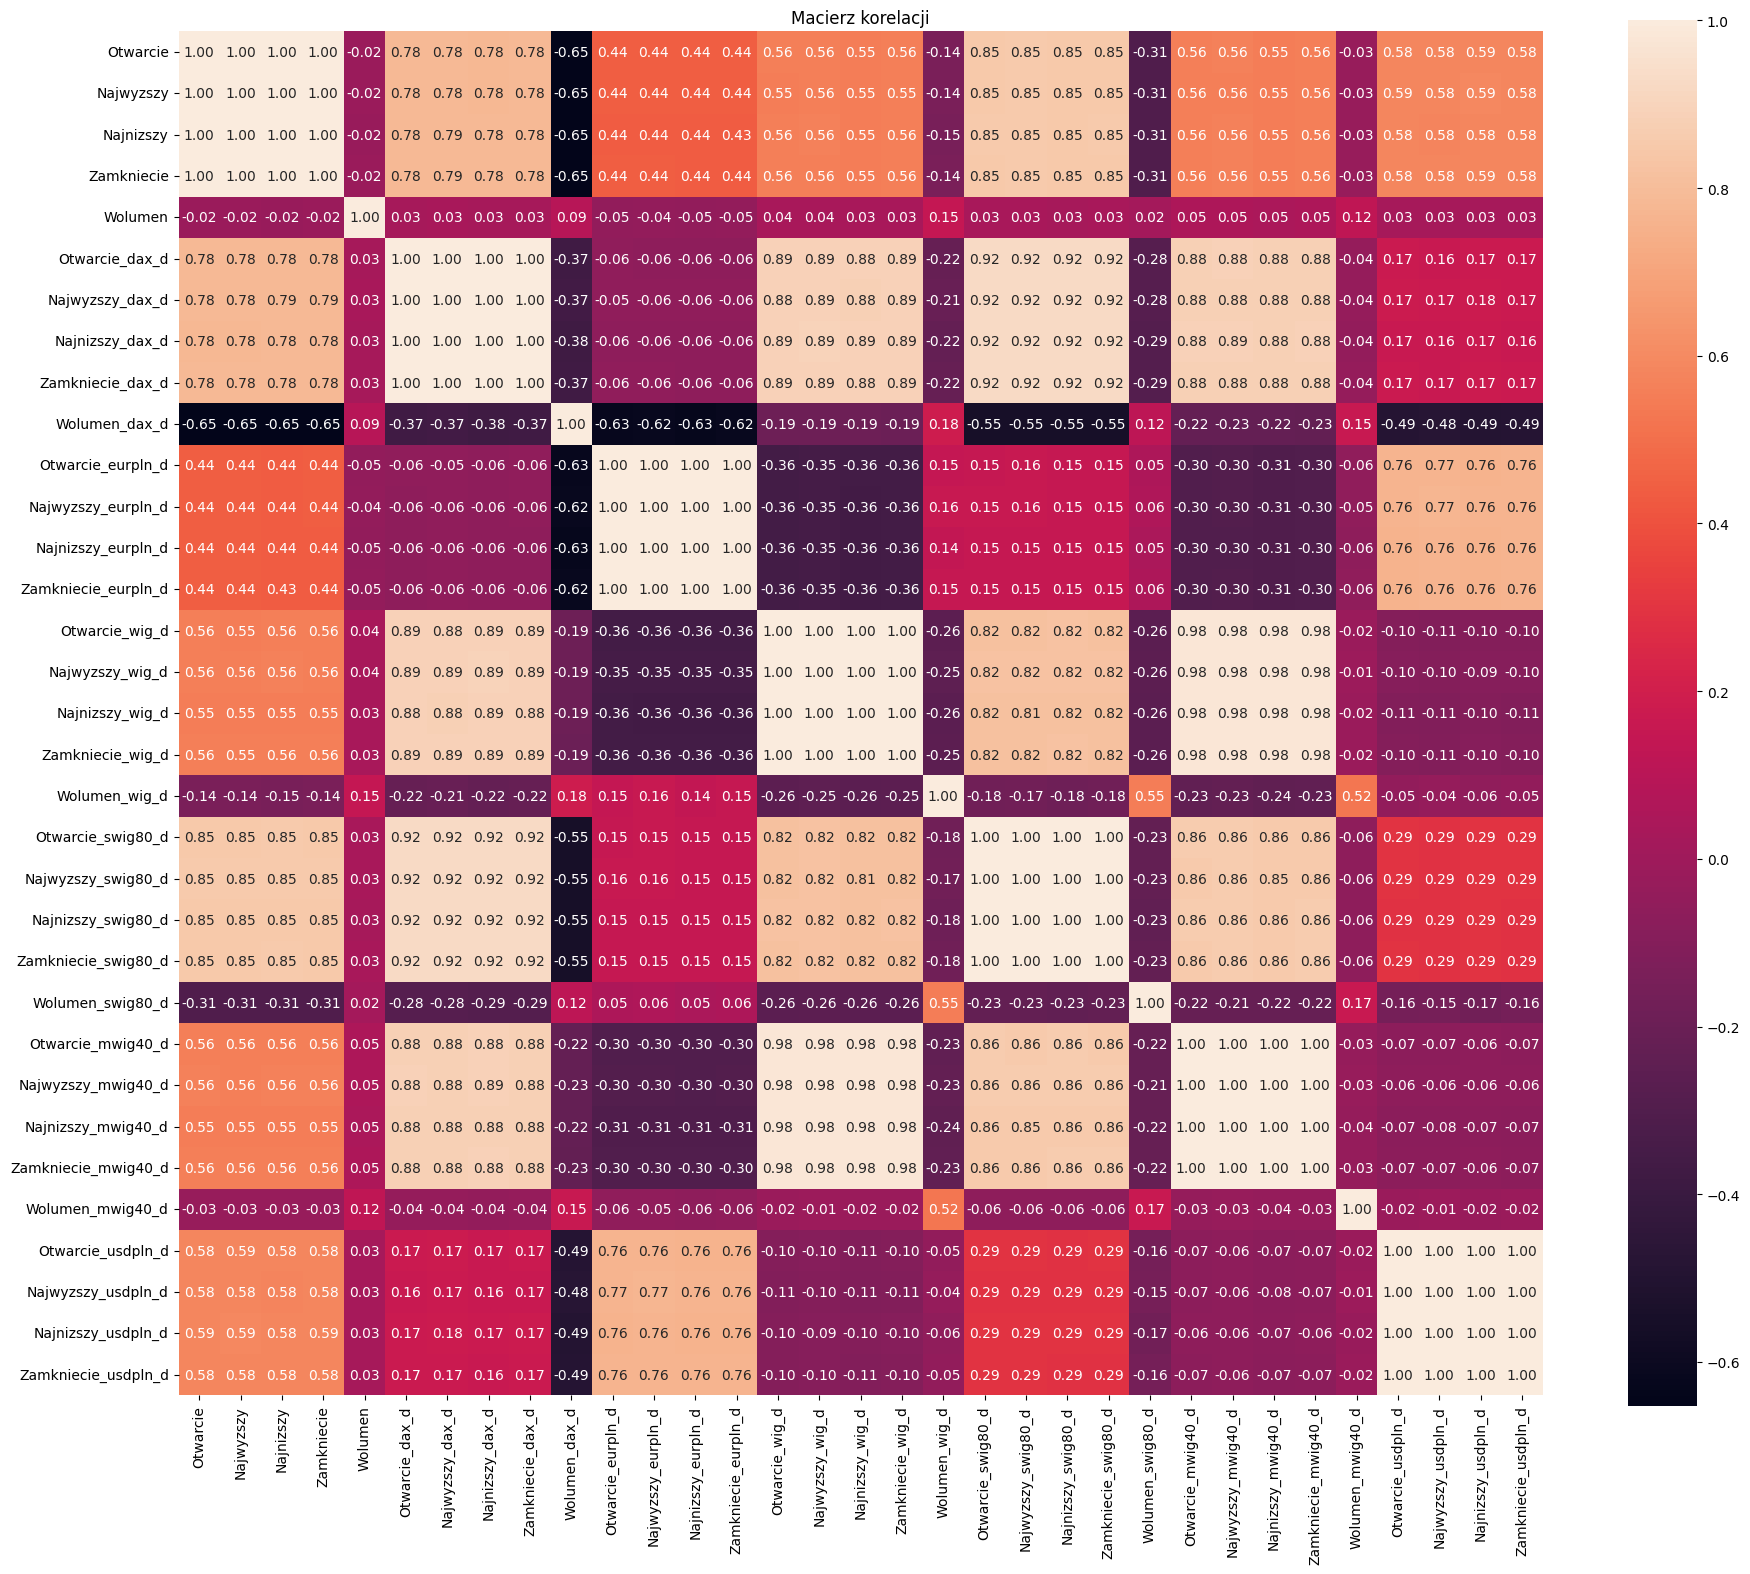

In [ ]:
data2 = data.drop(columns=['Data'])

plt.figure(figsize=(22, 18))
sns.heatmap(data2.corr(), annot=True, fmt=".2f", cmap="rocket", square=True)
plt.title("Macierz korelacji")
plt.show()

Correlation matrix presenting more precise values.

In [ ]:
corr = data2.corr()
corr.style.background_gradient('Oranges')

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Otwarcie_dax_d,Najwyzszy_dax_d,Najnizszy_dax_d,Zamkniecie_dax_d,Wolumen_dax_d,Otwarcie_eurpln_d,Najwyzszy_eurpln_d,Najnizszy_eurpln_d,Zamkniecie_eurpln_d,Otwarcie_wig_d,Najwyzszy_wig_d,Najnizszy_wig_d,Zamkniecie_wig_d,Wolumen_wig_d,Otwarcie_swig80_d,Najwyzszy_swig80_d,Najnizszy_swig80_d,Zamkniecie_swig80_d,Wolumen_swig80_d,Otwarcie_mwig40_d,Najwyzszy_mwig40_d,Najnizszy_mwig40_d,Zamkniecie_mwig40_d,Wolumen_mwig40_d,Otwarcie_usdpln_d,Najwyzszy_usdpln_d,Najnizszy_usdpln_d,Zamkniecie_usdpln_d
Otwarcie,1.000000,0.999562,0.999595,0.999101,-0.019569,0.782324,0.784613,0.780393,0.782817,-0.652971,0.440052,0.439579,0.439120,0.438419,0.555110,0.560245,0.550607,0.555770,-0.142751,0.851070,0.852209,0.850475,0.851273,-0.307620,0.556098,0.561477,0.551559,0.556712,-0.030841,0.584244,0.581289,0.586167,0.583288
Najwyzszy,0.999562,1.000000,0.999498,0.999631,-0.015874,0.781685,0.784179,0.779768,0.782350,-0.651849,0.440997,0.440739,0.439947,0.439306,0.553972,0.559418,0.549541,0.554990,-0.139123,0.850476,0.851688,0.849896,0.850788,-0.306631,0.555051,0.560617,0.550543,0.555900,-0.028357,0.585184,0.582337,0.586996,0.584151
Najnizszy,0.999595,0.999498,1.000000,0.999599,-0.023405,0.783920,0.786197,0.782142,0.784521,-0.651784,0.436402,0.435740,0.435395,0.434535,0.557467,0.562708,0.553298,0.558494,-0.145423,0.851652,0.852830,0.851211,0.852020,-0.308942,0.558110,0.563534,0.553828,0.558975,-0.030714,0.581611,0.578439,0.583483,0.580451
Zamkniecie,0.999101,0.999631,0.999599,1.000000,-0.019659,0.782547,0.785033,0.780811,0.783406,-0.651739,0.439178,0.438687,0.438101,0.437224,0.555119,0.560661,0.551048,0.556631,-0.141660,0.850709,0.851958,0.850271,0.851188,-0.307581,0.556113,0.561723,0.551867,0.557286,-0.028777,0.584165,0.581060,0.585920,0.582851
Wolumen,-0.019569,-0.015874,-0.023405,-0.019659,1.000000,0.031450,0.032946,0.030465,0.031163,0.091630,-0.048596,-0.043724,-0.048971,-0.045247,0.035675,0.037019,0.033353,0.034906,0.147485,0.031869,0.032039,0.031181,0.031542,0.020932,0.051969,0.052684,0.050539,0.051843,0.124404,0.026323,0.029587,0.026095,0.028585
Otwarcie_dax_d,0.782324,0.781685,0.783920,0.782547,0.031450,1.000000,0.999429,0.999344,0.998881,-0.371508,-0.058640,-0.059534,-0.060005,-0.060292,0.886811,0.888912,0.884408,0.886642,-0.218575,0.924319,0.924403,0.924755,0.924609,-0.284113,0.882509,0.884204,0.880439,0.882408,-0.038196,0.169665,0.164873,0.171834,0.167663
Najwyzszy_dax_d,0.784613,0.784179,0.786197,0.785033,0.032946,0.999429,1.000000,0.999072,0.999403,-0.368340,-0.054517,-0.055326,-0.056332,-0.056525,0.884736,0.887354,0.882413,0.885179,-0.213516,0.924493,0.924733,0.924946,0.924996,-0.282846,0.880806,0.882839,0.878707,0.881121,-0.036085,0.174855,0.170079,0.176556,0.172488
Najnizszy_dax_d,0.780393,0.779768,0.782142,0.780811,0.030465,0.999344,0.999072,1.000000,0.999504,-0.377009,-0.061818,-0.063496,-0.063370,-0.064321,0.888599,0.890844,0.887045,0.889333,-0.224185,0.924031,0.924130,0.924837,0.924673,-0.286173,0.883933,0.885705,0.882542,0.884533,-0.040121,0.166768,0.161292,0.168846,0.164116
Zamkniecie_dax_d,0.782817,0.782350,0.784521,0.783406,0.031163,0.998881,0.999403,0.999504,1.000000,-0.374337,-0.057213,-0.058742,-0.059138,-0.060026,0.885959,0.888597,0.884351,0.887211,-0.219605,0.924020,0.924239,0.924792,0.924814,-0.285342,0.881689,0.883725,0.880191,0.882630,-0.039133,0.171828,0.166461,0.173527,0.168845
Wolumen_dax_d,-0.652971,-0.651849,-0.651784,-0.651739,0.091630,-0.371508,-0.368340,-0.377009,-0.374337,1.000000,-0.626465,-0.618881,-0.628035,-0.620535,-0.189851,-0.191906,-0.192711,-0.194710,0.183090,-0.553455,-0.553194,-0.554726,-0.554339,0.118576,-0.223398,-0.226482,-0.224874,-0.227123,0.154393,-0.488501,-0.483562,-0.492371,-0.486262


#### **Internal Correlation of Variables Within the Same Index**

---

Variables such as Open, High, Close, etc., have correlations close to 1.0, which is expected (these are data from the same day, from the same index).

---

##### **USD/PLN and Stock Indices**

---

The USD/PLN exchange rates (e.g., `Open_usdpln_d`) have negative correlations with:  
* `Open_mwig40_d` (e.g., -0.065980)  
* `Open_wig_d` (e.g., -0.100928)  

---

##### **EUR/PLN and USD/PLN**

---

A notably high correlation between EUR/PLN and USD/PLN exchange rates, approximately 0.76.

---

##### **Correlations Among Indices**

---

`Open_mwig40_d`, `Open_wig_d`, and `Open_swig80_d` are very strongly positively correlated (around 0.85 - 0.97), indicating general synchronization within the Polish market.

`Open_dax_d` is also positively correlated with Polish indices (e.g., with `Open_mwig40_d` about 0.88), showing the influence of the German market.

---

##### **Volumes**

---

Volumes (`Volume`, `Volume_mwig40_d`, etc.) have low correlation with prices. This is typical, as volume often changes independently of price, although dependencies may appear during trends.


### Splitting the Dataset into Training and Testing Sets
<div style="background-color: pink; padding: 10px;">
    
### 4. Preparing model

</div>

#### Creating the Training Set

The training and testing datasets have been created.

The `split_data()` function is used to split the dataset `data` into two parts: training and testing sets.  
The function takes an argument `ratio` that specifies the percentage of data to allocate to the training set (default is 60%).  
The number of records for training (`N`) is calculated, and then the data is split in the ratio `N : remainder`.

In [ ]:
def split_data(data, ratio=0.6):
    N = int(len(data) * ratio) # lnumber of samples per class
    return data[:N], data[N:] # assignment of samples to variables

train_df, test_df = split_data(data, ratio=0.6)

print(train_df.shape)

(1194, 34)


This means that the training set contains 1,194 observations with 34 variables, while the original dataset had approximately 1,990 rows.


### Preparing Data for Training

We will be forecasting using an LSTM (Long Short-Term Memory) network.

The code prepares data for training the LSTM model based on a selected column — in this case, the "Close" price of the stock.

The `prepare_dataset_to_lstm()` function first selects values from this column, converts them to a numerical format, and then reshapes them into a two-dimensional array.

The next step is scaling the data using a selected tool (MinMaxScaler or StandardScaler), which facilitates the model’s learning process.

Finally, the data is split into training and testing sets in a specified ratio (80% for training, 20% for testing).  
This results in two transformed datasets, ready for further preparation of input sequences for the LSTM network.

In [ ]:
aticipated_variable = "Zamkniecie"

def prepare_dataset_to_lstm(aticipated_variable, train_df, ratio, scaler):
  dataset = train_df[aticipated_variable].values
  dataset = dataset.astype('float32')
  dataset = np.reshape(dataset, (-1, 1))
  dataset = scaler.fit_transform(dataset)

  train_size = int(len(dataset) * ratio)
  test_size = len(dataset) - train_size
  train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

  return train, test, scaler

# first dataset
train1, test1, scaler1 = prepare_dataset_to_lstm(aticipated_variable, train_df, ratio=0.8, scaler=MinMaxScaler(feature_range=(0, 1)))

# second dataset
train2, test2, scaler2 = prepare_dataset_to_lstm(aticipated_variable, train_df, ratio=0.8, scaler=StandardScaler())

### Creating Training Data

This code segment is responsible for preparing data in a format suitable for use by an LSTM network, which learns from time series sequences.

The `create_dataset_lstm()` function creates input datasets (X) and their corresponding target values (Y), based on a sliding window of length `look_back`.

This means the model will learn to predict the next value (e.g., closing price) based on a specified number of previous days (here: 20).

After the sequences are created, the data is further reshaped into a three-dimensional format required by LSTM: (number of samples, time steps, number of features).

The entire process is performed separately for two datasets — one prepared using MinMaxScaler and the other with StandardScaler.

In [ ]:
def create_dataset_lstm(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 20

# first dataset
X_train_1, Y_train_1 = create_dataset_lstm(train1, look_back)
X_test_1, Y_test_1 = create_dataset_lstm(test1, look_back)

X_train_1 = np.reshape(X_train_1, (X_train_1.shape[0], 1, X_train_1.shape[1]))
X_test_1 = np.reshape(X_test_1, (X_test_1.shape[0], 1, X_test_1.shape[1]))

print("First training and test data shapes:")
print(X_train_1.shape)
print(X_test_1.shape)

# second dataset
X_train_2, Y_train_2 = create_dataset_lstm(train2, look_back)
X_test_2, Y_test_2 = create_dataset_lstm(test2, look_back)

X_train_2 = np.reshape(X_train_2, (X_train_2.shape[0], 1, X_train_2.shape[1]))
X_test_2 = np.reshape(X_test_2, (X_test_2.shape[0], 1, X_test_2.shape[1]))

print("Second training and test data shapes:")
print(X_train_2.shape)
print(X_test_2.shape)

First training and test data shapes:
(934, 1, 20)
(218, 1, 20)
Second training and test data shapes:
(934, 1, 20)
(218, 1, 20)


The printed sizes in the console show how many sample sequences were generated for training and testing.

### Training the Model

In this code segment, a Sequential model is created where each layer has one input tensor and one output tensor.

The model accepts data with dimensions (1, number of features) — previously prepared as sequences for the LSTM network.

Next, a Dropout layer with a rate of 0.2 is added, which randomly "drops" some neurons during training.

This helps prevent overfitting, a situation where the model memorizes the training data too well and performs worse on new data.

The final Dense(1) layer returns a single output value — the predicted target variable (e.g., closing price).

The model is compiled using the mean squared error loss function, which works well for regression, and the Adam optimizer, which automatically adjusts the learning rate.

Training runs for up to 50 epochs, with EarlyStopping used to halt training if the validation loss (`val_loss`) does not improve for 10 consecutive epochs.  
This shortens training time and reduces the risk of overfitting.


First model:

In [ ]:
def lstm_model(X_train, Y_train, X_test, Y_test, batch_size=20):
  model = Sequential()
  model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(X_train, Y_train, epochs=50, batch_size=20, validation_data=(X_test, Y_test),
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)
  return model

Second model below:

In [ ]:
def lstm_model_modified(X_train, Y_train, X_test, Y_test, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64, return_sequences=False))  # LSTM layer added
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))      # additional dense layer
    model.compile(loss='mean_squared_error', optimizer='adam')

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1) # ReduceLROnPlateau added
    ]

    history = model.fit(
        X_train, Y_train,
        epochs=100, # epochs increased
        batch_size=batch_size,
        validation_data=(X_test, Y_test),
        callbacks=callbacks,
        verbose=1,
        shuffle=False)

    return model

In the modified version of the model, several changes were introduced.

The biggest novelty is the addition of an LSTM layer (Long Short-Term Memory) with 64 units. This is a special type of layer that “remembers” previous information from the data and can analyze it in the proper sequence. This is especially useful for forecasting time series data, such as daily stock prices.

An additional Dense layer with 16 neurons and ReLU activation was also added. This helps the model detect more complex, nonlinear relationships between variables, making it more flexible and effective.

During training, the model uses two helpful mechanisms. The first is EarlyStopping — it stops training when the model stops improving to save time and avoid overfitting. The second is ReduceLROnPlateau — it reduces the learning rate if the model stalls, helping it better fine-tune to the data.

In summary, all these changes help the model learn better, become more robust to noise, and improve its suitability for practical time series forecasting.



<div style="background-color: pink; padding: 10px;">
   
### 6. Evaluation of Machine Learning Models – Interpretation of Results

</div>

In [ ]:
def evaluation_model(model, X_train, X_test, Y_train, Y_test, scaler=None, testing=True):
    # Predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Removing an extra dimension, if present
    if train_predict.ndim == 3:
        train_predict = np.squeeze(train_predict, axis=-1)
    if test_predict.ndim == 3:
        test_predict = np.squeeze(test_predict, axis=-1)
    if Y_train.ndim == 3:
        Y_train = np.squeeze(Y_train, axis=-1)
    if Y_test.ndim == 3:
        Y_test = np.squeeze(Y_test, axis=-1)

    # Inverse scaling, if a scaler was provided
    if scaler:
        train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1)).flatten()
        test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1)).flatten()
        Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1)).flatten()
        Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()

    # Calculating metrics – training
    _mean_absolute_error = mean_absolute_error(Y_train, train_predict)
    _mean_squared_error = np.sqrt(mean_squared_error(Y_train, train_predict))

    # Calculating metrics – test
    _test_mae = mean_absolute_error(Y_test, test_predict)
    _test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

    print("Train Mean Absolute Error:", _mean_absolute_error)
    print("Train Root Mean Squared Error:", _mean_squared_error)
    print("-----------------------------")
    print("Test Mean Absolute Error:", _test_mae)
    print("Test Root Mean Squared Error:", _test_rmse)

    if testing:
        return Y_train, train_predict, Y_test, test_predict, _mean_absolute_error, _mean_squared_error, _test_mae, _test_rmse
    return Y_train, train_predict

In the `evaluation_model()` function, there is possibility to pass the previously used scaler.  
This allows both predictions and actual data to be transformed back to their original scale (e.g., Polish zloty), enabling meaningful interpretation and more accurate error calculation.

Additionally, the function also handles test data (`Y_test` and `test_predict`), allowing model evaluation not only on the training set but also on unseen data.

Training the first model:

In [ ]:
history_1 = lstm_model(X_train_1, Y_train_1, X_test_1, Y_test_1, batch_size=20)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1048 - val_loss: 0.5836
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318 - val_loss: 0.1101
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - val_loss: 0.0273
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0254 - val_loss: 0.0166
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0229 - val_loss: 0.0168
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0113
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.0130
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.0106
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0218 - val_loss: 0.0060
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_loss: 0.0082
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0179 - val_loss: 0.0108
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_lo

MWe can observe that for both:

* loss – the loss function on the training set  
* val-loss – the loss function on the validation set  

they decrease as the number of epochs increases, which means the model is learning well.

Training the second model:

In [ ]:
history_2 = lstm_model_modified(X_train_2, Y_train_2, X_test_2, Y_test_2, batch_size=32)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.5284 - val_loss: 1.4712 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0241 - val_loss: 0.2086 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0483 - val_loss: 0.0756 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0127 - val_loss: 0.2241 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0221 - val_loss: 0.1062 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - val_loss: 0.1897 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0140 - val_loss: 0.1072 - learning_rate: 0.0010
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - val_loss: 0.1831 - learning_rate: 0.00

The model stops training earlier because the EarlyStopping mechanism is used, which automatically ends training when the model's performance on the validation set stops improving.  

In this case, the monitored value is `val_loss` (validation loss), and the parameter `patience=10` means that if `val_loss` does not improve for 10 consecutive epochs, training will be stopped.  

This prevents unnecessary prolonged training, saving time and protecting against overfitting. Although the maximum number of epochs was set to 100, the model stops learning earlier once it considers that optimal parameters have been reached.


Evaluation of the first model:

In [ ]:
Y_train_eval_1, Y_pred_train_1, Y_test_eval_1, Y_pred_test_1, mae_1, rmse_1, test_mea_1, test_rmse_1 = evaluation_model(
    history_1,
    X_train_1,
    X_test_1,
    Y_train_1,
    Y_test_1,
    scaler=scaler1)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train Mean Absolute Error: 6.995716094970703
Train Root Mean Squared Error: 9.664564189054541
-----------------------------
Test Mean Absolute Error: 13.846368789672852
Test Root Mean Squared Error: 16.912225650837435


Evaluation of the second model:

In [ ]:
Y_train_eval_2, Y_pred_train_2, Y_test_eval_2, Y_pred_test_2, mae_2, rmse_2, test_mea_2, test_rmse_2 = evaluation_model(
    history_2,
    X_train_2,
    X_test_2,
    Y_train_2,
    Y_test_2,
    scaler=scaler2)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Train Mean Absolute Error: 6.80761194229126
Train Root Mean Squared Error: 8.890812072394771
-----------------------------
Test Mean Absolute Error: 21.34425926208496
Test Root Mean Squared Error: 25.30003913001853


The code presented evaluates two LSTM models built on the same dataset but scaled using different methods (MinMaxScaler for the first model and StandardScaler for the second).

Both models were assessed on training and test sets using the metrics: MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error).

Results:

**First model (MinMaxScaler):**

* Train MAE: 6.996  
* Train RMSE: 9.665  
* Test MAE: 13.05  
* Test RMSE: 16.91  

**Second model (StandardScaler):**

* Train MAE: 6.807  
* Train RMSE: 8.89  
* Test MAE: 21.34  
* Test RMSE: 25.30  

On the training set, the second model (StandardScaler) achieved slightly better results – lower errors indicate a somewhat better fit to the training data.

However, on the test set, the first model (MinMaxScaler) clearly performed better – it achieved significantly lower MAE and RMSE errors. This means it generalizes better to new, unseen data and is more useful for practical forecasting.

**Conclusion:**

The model based on MinMaxScaler handled forecasting real test data better and should be preferred in further analyses. Although the second model performed better on training data, its test results indicate overfitting.


### Visualization of the results

A function that displays the model visualization.

In [ ]:
def visualization(Y_train, train_predict):
  N = len(Y_train)
  aa=[x for x in range(N)]  # N denotes the number of features in the data point
  plt.figure(figsize=(8,4))
  plt.plot(aa, Y_train, marker='.', label="actual") #When . we change to * we will have instead of . -> *
  plt.plot(aa, train_predict, 'r', label="prediction")
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()  # adjust padding (dopełnienie) between and around support fields
  sns.despine(top=True) # we remove the ridge
  plt.subplots_adjust(left=0.07)  # the position of the left edge of the chart
  plt.title(" prediction")
  plt.xlabel('Time step', size=15)  # font size for time step 15
  plt.legend(fontsize=15)  # font size of legend items
  plt.show();  # we run event loops, search for all active figure objects and open one or more interactive windows.

Blue line – values from the original dataset

Red line – predicted values


Model 1 Visualization:

For training data


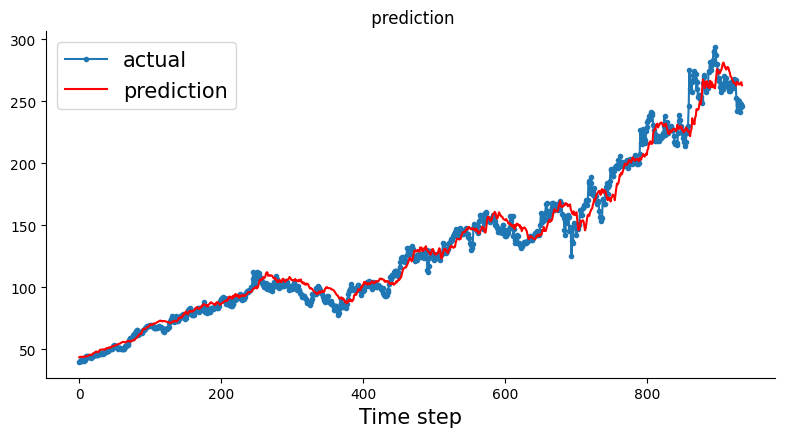

In [ ]:
# The data is not normalized in the chart
visualization(Y_train_eval_1, Y_pred_train_1)

The chart shows a very good fit of the model to the training data.

The red line almost completely overlaps with the blue line, indicating that the model has effectively learned the patterns present in the data.

Its predictions are precise, even with local fluctuations, confirming the high quality of the training. Such a result reflects a correct architecture and well-chosen parameters relative to the training set.

* The prediction (red line) closely matches the actual course values (blue points) — both in upward trends and short-term fluctuations.
* The model responds accurately to changes in direction and pace — it replicates not only the overall trend but also local corrections.
* Deviations between actual and predicted values are relatively small and evenly distributed, which indicates a high fit of the model to the training data.


For the test data

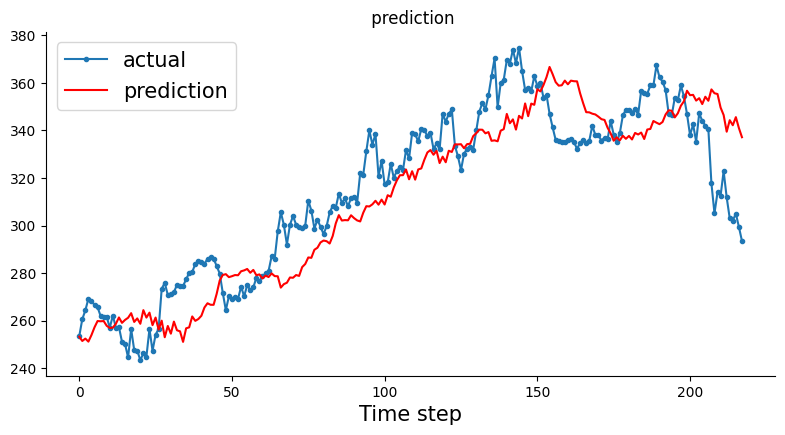

In [ ]:
# The data is not normalized in the chart
visualization(Y_test_eval_1, Y_pred_test_1)

The plot shows how Model 1 performs in predicting DINO stock prices on the test data. The red line (prediction) captures the general upward trend well but struggles to keep up with sudden changes.

The model predicts with a delay and overly smooths out fluctuations. Especially towards the end, it fails to respond to a sharp price drop. It is evident that the model captures the direction of changes but has difficulty accurately reflecting market dynamics.

* The model correctly reproduces the overall upward trend in the first part of the test data but struggles to capture rapid fluctuations and spikes — its predictions are significantly smoother.
* In the middle section, the model predicts the direction of changes correctly but with a delay — peaks and troughs in actual data are shifted relative to the prediction.
* In the final part (last ~50 points), the model clearly diverges from the actual values — it does not respond quickly enough to the sudden trend reversal.


Model visualization 2:

For training data

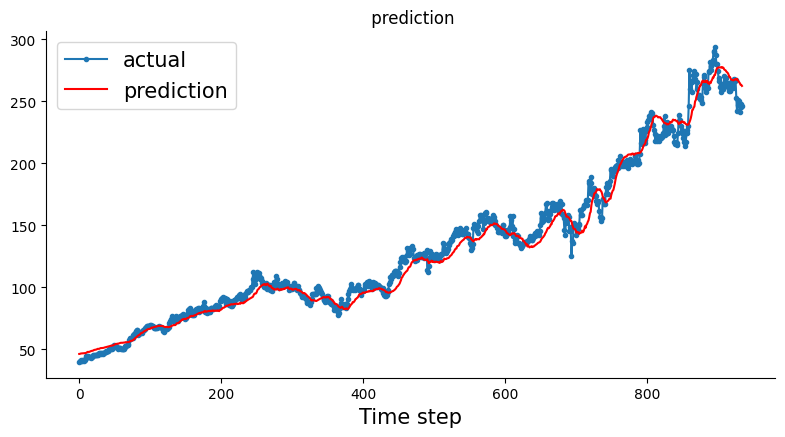

In [ ]:
# The data is not normalized in the chart
visualization(Y_train_eval_2, Y_pred_train_2)



The chart shows the fit of model 2 to the training data.

The red line (prediction) closely follows the long-term upward trend, but it is clear that the model smooths out short-term fluctuations and does not fully reflect local spikes and drops.

This means the model has learned the general direction of changes but has limited ability to track dynamic price movements.

* The model accurately captures the overall upward trend, indicating it has grasped the long-term dependencies well.
* The prediction (red line) is smoothed, meaning the model does not react to sudden spikes and drops visible in the actual data.
* The largest deviations between prediction and reality occur during periods of rapid changes, suggesting the model has limited capability to capture short-term volatility.


For test data

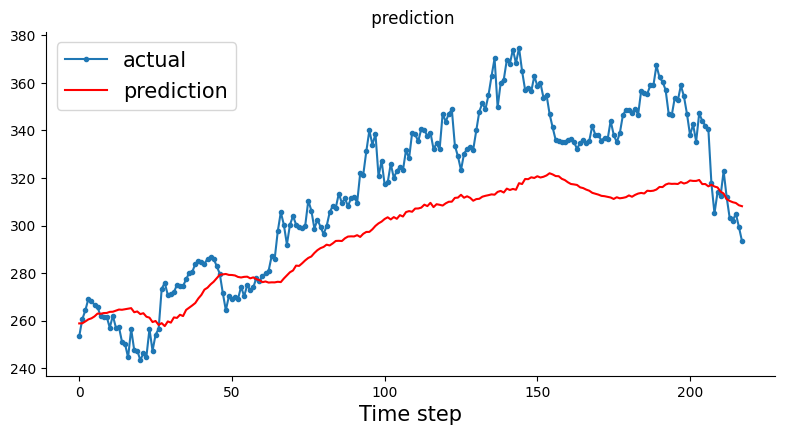

In [ ]:
# The data is not normalized in the chart
visualization(Y_test_eval_2, Y_pred_test_2)

The chart presents the results of model 2 on the test dataset and clearly highlights its limitations.

The red line, representing the predicted values, does not capture the variability of the actual stock prices (blue points), especially during periods of sharp rises and falls.

The model forecasts too "cautiously," producing a smoothed line that reacts to changes with a delay. As a result, the predictions significantly deviate from the actual price movements—especially in the latter part of the chart—indicating low model accuracy under market conditions and a weak ability to reflect the dynamics of stock prices.

* The model clearly fails to keep up with the real price changes—the red line (prediction) is heavily smoothed and reacts with delay to dynamic market movements.
* During strong rises and drops, the model loses accuracy—it does not predict sudden reversals and maintains its own flattened trend.
* The difference between the prediction and actual values increases significantly in the second half of the chart, confirming the low effectiveness of model 2 on test data and indicating a problem with generalization.


## Summary

This project compared the effectiveness of two LSTM models in forecasting the stock price of the company DINO, using different approaches to preprocessing input data – the first model was based on scaling with MinMaxScaler, while the second used StandardScaler. Both models were evaluated using MAE and RMSE metrics on both training and test datasets.

Model 1 (MinMaxScaler) achieved better results on the test data, with significantly lower MAE (13.05) and RMSE (16.91) compared to Model 2 (MAE: 21.34; RMSE: 25.30). This indicates that the first model generalized better and predicted unseen data more accurately. Although the second model fitted the training data slightly better, its performance on the test set was considerably worse, suggesting overfitting.

Visualizations showed that Model 1 closely tracked actual data — both the overall trend and short-term fluctuations, especially on the training set. On the test set, its predictions were somewhat smoothed and delayed but still relatively accurate. In contrast, Model 2 smoothed the data too much — its predictions lagged behind the dynamic price changes, increasing errors in the latter part of the test data plot.

From an architectural perspective, Model 1 was simpler, based on Dense and Dropout layers with EarlyStopping. Model 2 was extended with an LSTM layer, an additional Dense layer with ReLU activation, and a ReduceLROnPlateau mechanism, theoretically intended to improve flexibility and adaptability. However, in practice — with the given dataset — these changes did not translate into better predictive performance.

**Conclusions:**

* The LSTM model with MinMaxScaler proved more effective and stable in predicting real data, despite a simpler architecture.
* The model with an LSTM layer and StandardScaler overfitted the training data and struggled with generalization.
* Key factors affecting forecast quality included not only scaling but also the model’s ability to track local changes and react to market dynamics.

**Potential improvements:**

* Expand the input dataset with additional variables (e.g., volume, technical indicators, indices).
* Test deeper LSTM or GRU architectures with a larger look_back window.
* Conduct more thorough model validation across different market periods and conditions.

This project confirms that LSTM networks can be an effective tool for forecasting stock market data, but their success strongly depends on proper data preparation and well-considered model architecture.
